# Effective Beam Response

This notebook demonstrates how to **estimate the effective beam response** of an IViS reconstruction, which varies with the strength of the regularization (e.g., Laplacian filtering).

## Download

You can download the data directory `data_tutorials` using:

```bash
wget https://www.mso.anu.edu.au/~amarchal/shared/ivis/data_tutorials.zip
unzip data_tutorials.zip -d data_tutorials
rm data_tutorials.zip
```

Kindly provided by Enrico Di Teodoro (UniFI) and Karlie Noon (RSAA/ANU).

## Method
<div style="text-align: justify;">
    
> We inject a delta function (point source) into an otherwise empty map and simulate visibilities using a realistic uv-coverage from a single MeerKAT beam.
>
> We then reconstruct the image using IViS to estimate the response.
>
> This response **differs from a traditional "restored" beam**, as it results from a non-linear reconstruction that depends on the intrinsic signal shape, signal-to-noise ratio, and the strength of spatial regularization.
>
> While this beam characterizes IViS’s response to a point source for a **given uv-sampling**, the effective resolution for extended emission may differ due to the nonlinearity of the reconstruction.
>
> We therefore **caution against interpreting this beam** as a global PSF of the reconstruction. Nonetheless, it provides a useful starting point for estimating the shape and size of a **theoretical effective beam**.
>
> The resulting image **can be reconvolved with a known kernel**, depending on the needs of the scientific application.
>
> Feel free to vary the scaling for the noise, or the ``lambda_r``, the hyper-parameter controling the Laplacian filtering, to see how the response varies.

</div>

In [43]:
import glob
from tqdm import tqdm as tqdm

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from radio_beam import Beam
from astropy import units as u
from reproject import reproject_interp

from ivis.io import DataProcessor
from ivis.imager import Imager3D
from ivis.logger import logger
from ivis.utils import dutils
from ivis.readers import CasacoreReader
from ivis.types import VisIData

from ivis.models import ClassicIViS3D

path_ms = "./data_tutorials/ivis_data_1beam/msl_mw/" #directory of measurement sets    
path_beams = "./data_tutorials/ivis_data_1beam/BEAMS/" #directory of primary beams
path_sd = None #path single-dish data
pathout = "./data_tutorials/ivis_data_1beam/" #path where data will be packaged and stored

#REF WCS INPUT USER
filename = "./data_tutorials/ivis_data_1beam/MW-C10_mom0th_NHI.fits"
target_header = fits.open(filename)[0].header
shape = (target_header["NAXIS2"],target_header["NAXIS1"])
    
#create data processor
data_processor = DataProcessor(path_ms, path_beams, path_sd, pathout)

# pre-compute pb and interpolation grids — this can be commented after first compute
logger.disabled = True
data_processor.compute_pb_and_grid(target_header, fitsname_pb="reproj_pb.fits", fitsname_grid="grid_interp.fits") 
logger.disabled = False

pb, grid = data_processor.read_pb_and_grid(fitsname_pb="reproj_pb.fits", fitsname_grid="grid_interp.fits")

#Dummy sd array
sd = np.zeros(shape)
#Dummy Beam sd
beam_sd = Beam(1*u.deg, 1*u.deg, 1.e-12*u.deg)

[2025-08-23 01:35:20 UTC] [IViS] [info] [Initialize DataProcessor ]
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


In [44]:
# -------------------
# Read visibilities into VisIData dataclass
# -------------------
reader = CasacoreReader(
    prefer_weight_spectrum=False,
    keep_autocorr=False,
    n_workers=4)

I: VisIData = reader.read_blocks_I(
    path_ms,
    uvmin=0.0,
    uvmax=np.inf,
    chan_sel=slice(0, 1),
)

[2025-08-23 01:35:21 UTC] [IViS] [info] [BLOCK] Loading block from: ./data_tutorials/ivis_data_1beam/msl_mw/
[2025-08-23 01:35:21 UTC] [IViS] [info] [BLOCK] Loading 1 beam(s) from: ./data_tutorials/ivis_data_1beam/msl_mw/
[2025-08-23 01:35:21 UTC] [IViS] [info] [BLOCK] Parallel read with 4 workers (order-preserving; selective)
[2025-08-23 01:35:21 UTC] [IViS] [info]     [MS] Opening: ./data_tutorials/ivis_data_1beam/msl_mw/MW-C10_2_MW_chan_-32kms.ms
[2025-08-23 01:35:21 UTC] [IViS] [info]     [MS] Done: MW-C10_2_MW_chan_-32kms.ms  rows=1068720
[2025-08-23 01:35:21 UTC] [IViS] [info] [BLOCK] Done: nchan=1, nbeam=1, nvis_max=1068720 (read 1/1 beams)


### Injecting a 1 Jy point source at the center

In [54]:
cell_size = (np.abs(target_header["CDELT2"]) *u.deg).to(u.arcsec).value
sky_model = np.zeros((1,shape[0],shape[1]), dtype=np.float32)
sky_model[0][shape[0] // 2, shape[1] // 2] = 1.0 / (cell_size ** 2)  # Jy / arcsec^2

### Simulated visibilities (using IViS forward model)

In [55]:
#Model visibilities with IVis forward single frequency model
image_processor = Imager3D(I,      # visibilities
                         pb,            # array of primary beams
                         grid,          # array of interpolation grids
                         None,            # single dish data in unit of Jy/arcsec^2
                         None,       # beam of single-dish data in radio_beam format
                         target_header, # header on which to image the data
                         sky_model,   # init array of parameters
                         0,       # maximum number of iterations
                         0,     # hyper-parameter single-dish
                         False,    # impose a positivity constaint
                         0,        # device: 0 is GPU; "cpu" is CPU
                         0,
                         beam_workers=1)

model = ClassicIViS3D()
model_vis =  image_processor.forward_model(model=model)

[2025-08-23 01:36:53 UTC] [IViS] [info] CUDA unavailable or invalid index; using CPU.
[2025-08-23 01:36:53 UTC] [IViS] [info] CUDA unavailable or invalid index; using CPU.
[2025-08-23 01:36:53 UTC] [IViS] [info] [Initialize Imager3D       ]
[2025-08-23 01:36:53 UTC] [IViS] [info] Number of iterations to be performed by the optimizer: 0
[2025-08-23 01:36:53 UTC] [IViS] [warning] lambda_sd = 0 — No short-spacing correction.
[2025-08-23 01:36:53 UTC] [IViS] [info] Optimizer not bounded - Positivity == False


### Adding realistic noise from the MeerKAT data beam

In [62]:
#Add noise
fact=1 #Scale the noise with this if needed
noise_real = np.random.normal(loc=0.0, scale=I.sigma_I*fact)
noise_imag = np.random.normal(loc=0.0, scale=I.sigma_I*fact)
noise = noise_real + 1j * noise_imag

# Add realistic thermal noise to the model visibilities
I.data_I = model_vis + noise

### Imaging using IViS

In [66]:
#user parameters
max_its = 20
lambda_sd = 0 #not relevant here
lambda_r = 1 #Control the strength of the Laplacian filtering
cost_device = 0#"cpu" #0 is GPU and "cpu" is CPU
optim_device = 0
positivity = True #Set to true because we know here the sky is positive for a point source

#Initial parameters (zero array)
init_params = np.zeros((1,shape[0],shape[1]), dtype=np.float32)

#create image processor
image_processor = Imager3D(I,      # visibilities
                         pb,            # array of primary beams
                         grid,          # array of interpolation grids
                         sd,            # single dish data in unit of Jy/arcsec^2
                         beam_sd,       # beam of single-dish data in radio_beam format
                         target_header, # header on which to image the data
                         init_params,   # init array of parameters
                         max_its,       # maximum number of iterations
                         lambda_sd,     # hyper-parameter single-dish
                         positivity,    # impose a positivity constaint
                         cost_device,        # device: 0 is GPU; "cpu" is CPU
                         optim_device,
                         beam_workers=1)
#get image
model = ClassicIViS3D(lambda_r=lambda_r)
result = image_processor.process(model=model, units="Jy/arcsec^2") #"Jy/arcsec^2" or "K"

[2025-08-23 01:39:46 UTC] [IViS] [info] CUDA unavailable or invalid index; using CPU.
[2025-08-23 01:39:46 UTC] [IViS] [info] CUDA unavailable or invalid index; using CPU.
[2025-08-23 01:39:46 UTC] [IViS] [info] [Initialize Imager3D       ]
[2025-08-23 01:39:46 UTC] [IViS] [info] Number of iterations to be performed by the optimizer: 20
[2025-08-23 01:39:46 UTC] [IViS] [warning] lambda_sd = 0 — No short-spacing correction.
[2025-08-23 01:39:46 UTC] [IViS] [info] Optimizer bounded - Positivity == True
[2025-08-23 01:39:46 UTC] [IViS] [warning] Optimizer bounded - Because there is noise in the data, it is generally not recommanded to add a positivity constaint.
[2025-08-23 01:39:47 UTC] [IViS] [info] Starting optimisation: SciPy L-BFGS-B (CPU optimizer), cost on cpu
[2025-08-23 01:39:49 UTC] [IViS] [info] [PID 34145] Total cost: 1.42734e+06
[2025-08-23 01:39:53 UTC] [IViS] [info] [PID 34145] Total cost: 1.39178e+10
[2025-08-23 01:39:53 UTC] [IViS] [info] [PID 34145] Total cost: 1.27128e+

## Zoom in / cutout at the center of the image

In [67]:
#Cutout
ny, nx = shape
cy, cx = ny // 2, nx // 2  # center coordinates

zoom = 20  # pixels around center
cutout = result[0][cy - zoom:cy + zoom + 1, cx - zoom:cx + zoom + 1]

## Fitting an elliptical Gaussian model

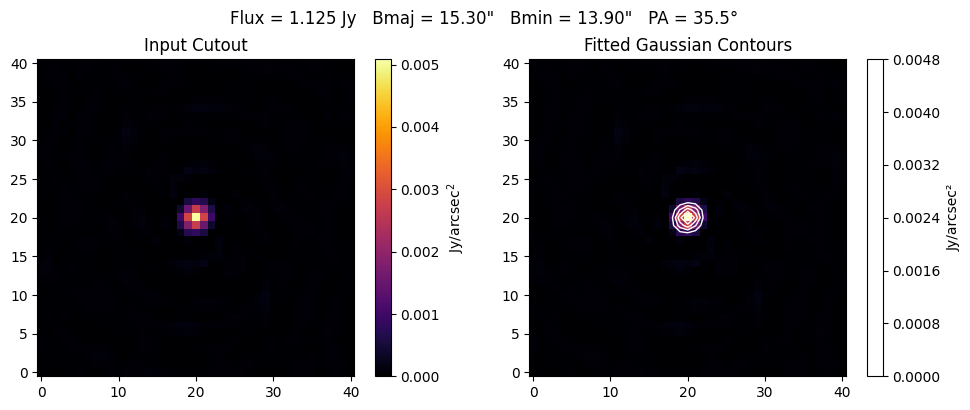

In [68]:
flux, Bmaj, Bmin, theta = dutils.fit_elliptical_gaussian(cutout, pixel_scale_arcsec=cell_size)